In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [24]:
#Essentials
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import matplotlib.pyplot as plt

#sklearn "magic"
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from  imblearn.over_sampling import SMOTE


#Not sure about these ones yet
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from collections import Counter


#Different scores
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve,f1_score, fbeta_score, roc_curve

#Nice to have
from mlxtend.plotting import plot_decision_regions, plot_confusion_matrix
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display 
from ipywidgets import interactive, FloatSlider
#interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

%matplotlib inline

In [3]:
# Helper function for printing confusion matrices (see: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823)
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [4]:
# Postgres info to connect

connection_args = {
    'host': '18.222.192.127', 
    'user': 'ubuntu',    # username
    'dbname': 'student_grades',   # DB that we are connecting to
    'port': 5432         # port we opened on AWS
}

# We will talk about this magic Python trick!
connection = pg.connect(**connection_args)

In [5]:
### Let's combine the two SQL tables into one

append_query = """SELECT * 
                    FROM maths_grades

                    UNION ALL

                    SELECT * 
                    FROM portuguese_grades
                    """

grades = pd_sql.read_sql(append_query, connection)

In [6]:
grades.head()

,sex,age,address,famsize,Pstatus,Medu,Fedu,guardian,traveltime,studytime,...,freetime,goout,Dalc,Walc,health,absences,G3,discipline,final_grade_label,final_grade_segment
0,F,18,U,GT3,A,4,4,mother,2,2,...,3,4,1,1,3,6,6,maths,Fail,Fail
1,F,17,U,GT3,T,1,1,father,1,2,...,3,3,1,1,3,4,6,maths,Fail,Fail
2,F,15,U,LE3,T,1,1,mother,1,2,...,3,2,2,3,3,10,10,maths,Pass,Sufficient
3,F,15,U,GT3,T,4,2,mother,1,3,...,2,2,1,1,5,2,15,maths,Pass,Good
4,F,16,U,GT3,T,3,3,father,1,2,...,3,2,1,2,5,4,10,maths,Pass,Sufficient


### Let's dummify some variables

In [7]:
grades.columns

Index(['sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
       'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
       'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
       'G3', 'discipline', 'final_grade_label', 'final_grade_segment'],
      dtype='object')

In [8]:
#dummify sex (M=0, F=1)
grades['sex'].replace({'M': 0, 'F': 1}, inplace=True, axis=0)

#dummify address (U(urban)=0, R(rural)=1)
grades['address'].replace({'U': 0, 'R': 1}, inplace=True, axis=0)

#dummify famsize (LE3(less than/equal to 3)=0, GT3(greater than 3)=1)
grades['famsize'].replace({'LE3': 0, 'GT3': 1}, inplace=True, axis=0)

#dummify Pstatus(parent status) (T(together)=0, A(apart)=1)
grades['Pstatus'].replace({'T': 0, 'A': 1}, inplace=True, axis=0)

#dummify guardian (other=0, mother=1, father=2)
grades['guardian'].replace({'other': 0, 'mother': 1, 'father': 2}, inplace=True, axis=0)

#dummify discipline (maths=0, portuguese=1)
grades['discipline'].replace({'maths': 0, 'portuguese': 1}, inplace=True, axis=0)

#drop G3 column (obviously!)
grades.drop(columns='G3', inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4480: UserWarning: the "axis" argument is deprecated and will be removed inv0.13; this argument has no effect
  warnings.warn('the "axis" argument is deprecated '


### Feature and target analysis

In [9]:
print(grades['final_grade_label'].value_counts(), '\n')
print('% of Pass:', str(round(814 / 1044, 2)))
print('% of Fail:', str(round(230 / 1044, 2)), '\n')
print('Pass to Fail ratio in the dataset:', str(int((814 / 1044)*100))+':'+str(int((230 / 1044)*100)))
print('Percentage of Majority grade (Pass)', str(round((814 / 1044) *100, 0)))

Pass    814
Fail    230
Name: final_grade_label, dtype: int64 

% of Pass: 0.78
% of Fail: 0.22 

Pass to Fail ratio in the dataset: 77:22
Percentage of Majority grade (Pass) 78.0


> **This is not good!** I should look into oversampling or undersampling further down the line

In [10]:
feat, grade_label = grades.iloc[:, :-2], grades.iloc[:, -2]

In [11]:
#print(feat.head())
#print(grade_label.head())

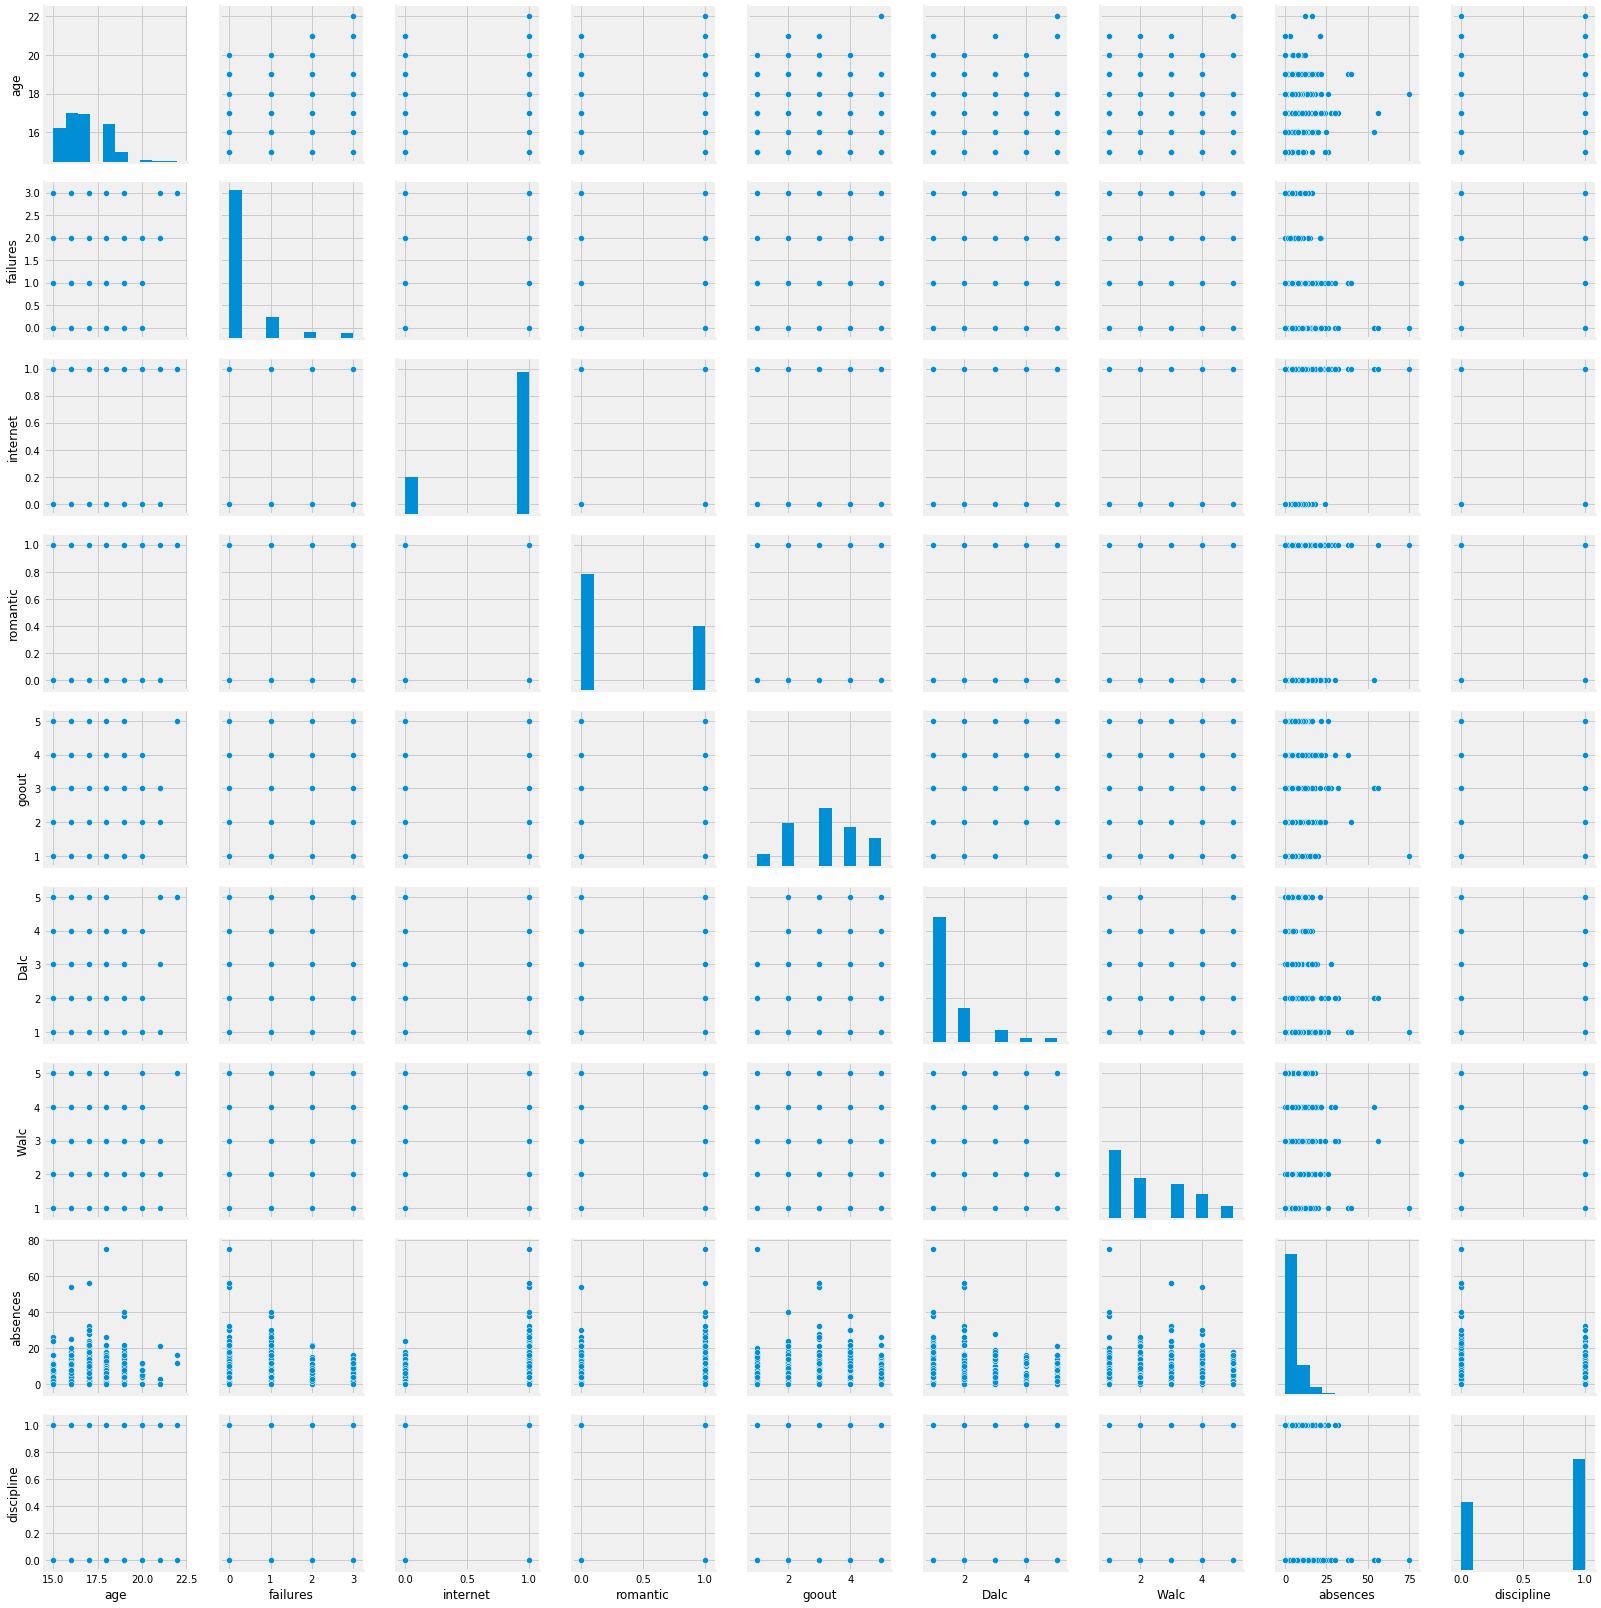

In [12]:
sns.pairplot(grades[['age', 'failures', 'internet', 'romantic', 'goout', 'Dalc', 'Walc', 'absences', 'discipline', 'final_grade_label']]);

# 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
#        'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup',
#        'famsup', 'paid', 'activities', 'higher', 'internet', 'romantic',
#        'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences',
#        'discipline', 'final_grade_label', 'final_grade_segment'

In [13]:
feat_train, feat_test, grade_label_train, grade_label_test = train_test_split(feat, grade_label, test_size=0.3, random_state=42, stratify=grade_label)

In [14]:
#Naive way of getting feature importance (without oversampling or undersampling)

RF_model = RandomForestClassifier(n_estimators=10)
RF_model.fit(feat_train, grade_label_train)

grade_label_predict_RF = RF_model.predict(feat_train)
recall_RF = recall_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')
precision_RF = precision_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')
accuracy_RF = accuracy_score(grade_label_train, grade_label_predict_RF)
f1_RF = f1_score(grade_label_train, grade_label_predict_RF, pos_label='Pass')
print('Random Forest recall score is', str(round(recall_RF, 4)))
print('Random Forest precision score is', str(round(precision_RF, 4)))
print('Random Forest accuracy score is', str(round(accuracy_RF, 4)))
print('Random Forest F1 score is', str(round(f1_RF, 4)), '\n')

Random Forest recall score is 0.9947
Random Forest precision score is 0.9982
Random Forest accuracy score is 0.9945
Random Forest F1 score is 0.9965 



In [15]:
feat_imp = []
for feat, imp in zip([f for f in feat_train.columns], RF_model.feature_importances_):
    feat_imp.append((feat, round(imp, 3)))

for feat, imp in sorted(feat_imp, key=lambda x: x[1], reverse=True):
    print(str(feat)+':', str(imp))

failures: 0.142
absences: 0.099
age: 0.054
freetime: 0.051
discipline: 0.05
goout: 0.049
Walc: 0.045
higher: 0.043
Medu: 0.04
famrel: 0.038
health: 0.036
Fedu: 0.033
guardian: 0.032
traveltime: 0.03
paid: 0.026
studytime: 0.025
activities: 0.025
Dalc: 0.025
famsize: 0.024
famsup: 0.022
romantic: 0.022
sex: 0.021
address: 0.021
schoolsup: 0.021
internet: 0.021
Pstatus: 0.007


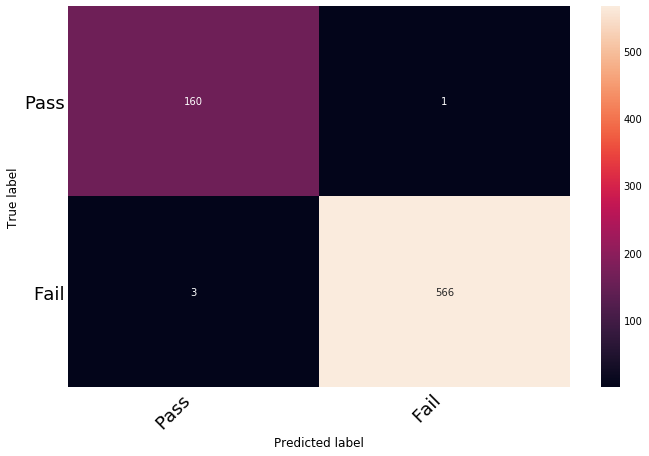

In [16]:
#Let's look at the confusion matrix
RF_conf_mat = confusion_matrix(grade_label_train, grade_label_predict_RF)
confusion_matrix = print_confusion_matrix(RF_conf_mat, ['Pass', 'Fail'])

In [19]:
RF_cross_val = cross_val_score(RF_model, feat_train, grade_label_train, scoring='accuracy', cv = 10)

The mean of 10 fold cross validation accuracy score on Random Forest model is 0.801


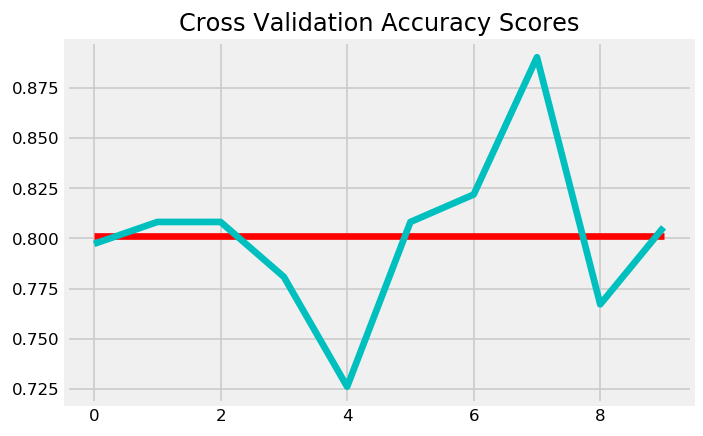

In [21]:
plt.figure(dpi=120)
plt.title('Cross Validation Accuracy Scores')
plt.plot([np.mean(RF_cross_val) for score in RF_cross_val], color='r')
plt.plot(RF_cross_val, color='c');

print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))

### Can we do better with oversampling or undersampling?

In [26]:
feat_train_smoted, grade_label_train_smoted = SMOTE(random_state=42).fit_sample(feat_train, grade_label_train)
Counter(grade_label_train_smoted)

In [28]:
RF_model_smoted = RandomForestClassifier(n_estimators=10)
RF_model_smoted.fit(feat_train_smoted, grade_label_train_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

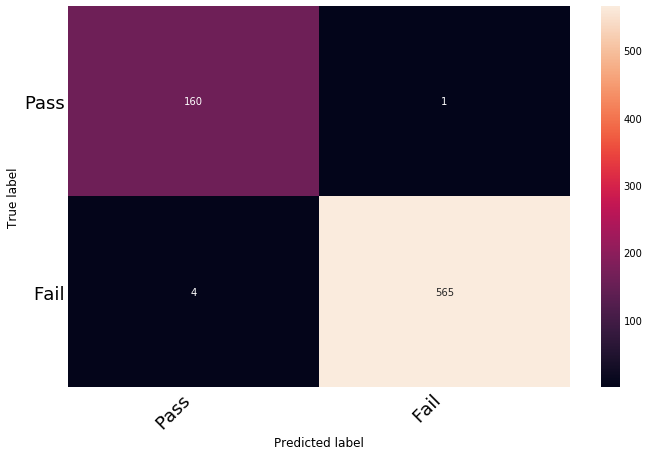

In [30]:
cm = print_confusion_matrix(confusion_matrix(grade_label_train, RF_model_smoted.predict(feat_train)), ['Pass', 'Fail'])


> WhaaaAAAt?! It does worse when I smote it??

The mean of 10 fold cross validation accuracy score on Random Forest model is 0.781


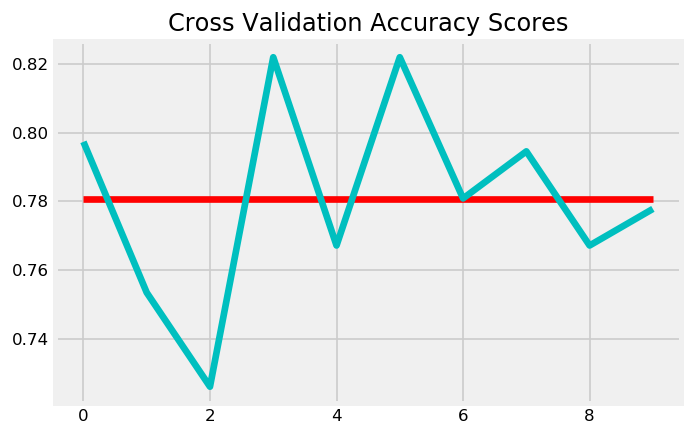

In [31]:
#Checking accuracy score on smoted model
RF_cross_val = cross_val_score(RF_model_smoted, feat_train, grade_label_train, scoring='accuracy', cv = 10)

plt.figure(dpi=120)
plt.title('Cross Validation Accuracy Scores')
plt.plot([np.mean(RF_cross_val) for score in RF_cross_val], color='r')
plt.plot(RF_cross_val, color='c');

print('The mean of 10 fold cross validation accuracy score on Random Forest model is', str(round(np.mean(RF_cross_val), 3)))